In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
import shape # for model interpretability

In [2]:
df = pd.read_csv("../data/preprocessed_data.csv") 
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Ratio_Balance_Age,Ratio_Salary_Age,Engagement_Score,Ratio_Products_Age,Relative_Salary,Ratio_CreditScore_Age,Zero_Balance_HasCrCard,Low_Balance_Active,Active_HasCrCard,Log_Salary
0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,...,2527.303265,2830.627551,4.0,0.040816,1.161679,13.938776,False,False,1.0,11.840081
1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,...,0.000000,4890.790667,4.0,0.066667,1.248591,20.266667,True,True,1.0,11.896313
2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,...,0.000000,2964.800000,3.0,0.031250,0.807356,16.843750,True,True,1.0,11.460311
3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,...,0.000000,4561.459744,2.0,0.051282,1.511382,13.589744,False,False,0.0,12.088965
4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,...,0.000000,2594.403111,4.0,0.044444,0.993504,13.622222,True,True,1.0,11.667783


In [3]:
# Define features and target variable
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [4]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Identify numerical and categorical columns
num_var = X.select_dtypes(include=["float64", "int64"]).columns
cat_var = X.select_dtypes(include=["object","category"]).columns

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),           
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
    ]
)

In [7]:
y.value_counts()

Exited
0    12010
1     2990
Name: count, dtype: int64

In [8]:
# Logistic Regression Model
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train and evaluate Logistic Regression
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


In [9]:
# Evaluation function
def evaluate_model(y_test, y_pred, y_prob):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()


Accuracy: 0.8116666666666666
Precision: 0.5174234424498416
Recall: 0.8193979933110368
F1-score: 0.6343042071197411
AUC: 0.8911971350518938

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      2402
           1       0.52      0.82      0.63       598

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.83      3000



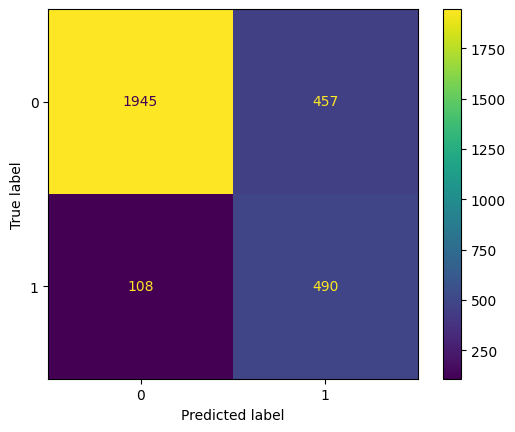

In [10]:
evaluate_model(y_test, y_pred, y_prob)

Accuracy: 0.8833333333333333
Precision: 0.6845238095238095
Recall: 0.7692307692307693
F1-score: 0.7244094488188977
AUC: 0.9297812023982245

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.68      0.77      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.84      0.83      3000
weighted avg       0.89      0.88      0.89      3000



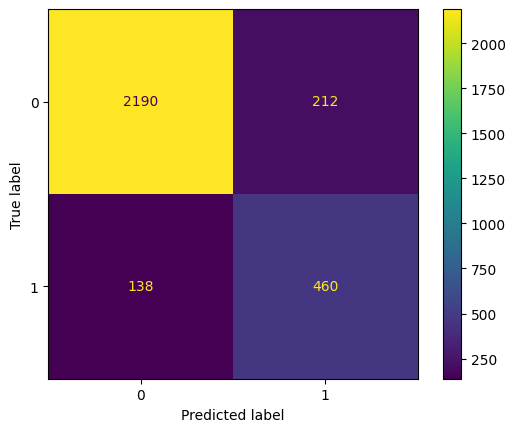

In [11]:
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

evaluate_model(y_test, y_pred_rf, y_prob_rf)


Accuracy: 0.882
Precision: 0.6728045325779037
Recall: 0.794314381270903
F1-score: 0.7285276073619632
AUC: 0.9313044592159823

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2402
           1       0.67      0.79      0.73       598

    accuracy                           0.88      3000
   macro avg       0.81      0.85      0.83      3000
weighted avg       0.89      0.88      0.89      3000



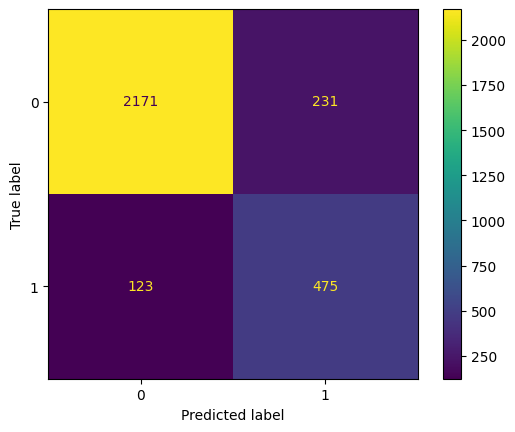

In [12]:
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,   # gérer déséquilibre
        eval_metric='logloss',
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

evaluate_model(y_test, y_pred_xgb, y_prob_xgb)


# Feauture selection
# Select the beste optimization methode between gridsearch and optuna
# validation croise pour deteimer la bon methode 

Original training set class distribution:
Exited
0    9608
1    2392
Name: count, dtype: int64

After preprocessing, X_train shape: (12000, 22)


c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



After SMOTE training set class distribution:
Exited
0    9608
1    9608
Name: count, dtype: int64
After SMOTE, X_train_smote shape: (19216, 22)

XGBoost with SMOTE - Model Performance:
Accuracy: 0.8893333333333333
Precision: 0.71875
Recall: 0.7307692307692307
F1-score: 0.724709784411277
AUC: 0.9302051801870793

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2402
           1       0.72      0.73      0.72       598

    accuracy                           0.89      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.89      0.89      0.89      3000


XGBoost with SMOTE - Model Performance:
Accuracy: 0.8893333333333333
Precision: 0.71875
Recall: 0.7307692307692307
F1-score: 0.724709784411277
AUC: 0.9302051801870793

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2402
           1       0.72      0.73  

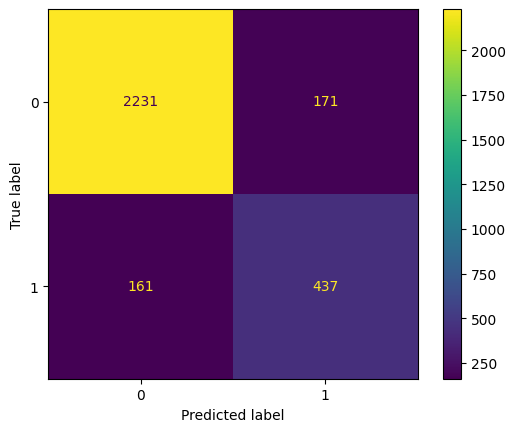

In [15]:
# SMOTE for balancing classes (CORRECT: preprocess FIRST, then apply SMOTE)
from imblearn.over_sampling import SMOTE

print("Original training set class distribution:")
print(pd.Series(y_train).value_counts())

# Step 1: Fit preprocessor on training data and transform
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("\nAfter preprocessing, X_train shape:", X_train_preprocessed.shape)

# Step 2: Apply SMOTE to preprocessed training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

print("\nAfter SMOTE training set class distribution:")
print(pd.Series(y_train_smote).value_counts())
print("After SMOTE, X_train_smote shape:", X_train_smote.shape)

# Step 3: Train XGBoost on SMOTE-balanced data
xgb_smote = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,   # balanced by SMOTE, no need for weighting
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

xgb_smote.fit(X_train_smote, y_train_smote)

# Step 4: Predict on preprocessed test data
y_pred_xgb_smote = xgb_smote.predict(X_test_preprocessed)
y_prob_xgb_smote = xgb_smote.predict_proba(X_test_preprocessed)[:, 1]

print("\nXGBoost with SMOTE - Model Performance:")
evaluate_model(y_test, y_pred_xgb_smote, y_prob_xgb_smote)
